In [1]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [2]:
import os
os.environ['KAGGLE_USERNAME']='harshaldharpure'
os.environ['KAGGLE_KEY']='b484abbe937c85cdd058fc34fbf624e1'

In [3]:
! kaggle datasets download -d xinzone/surface-crack

 97% 41.0M/42.4M [00:03<00:00, 18.7MB/s]
100% 42.4M/42.4M [00:03<00:00, 13.0MB/s]


In [4]:
!unzip -q "/content/surface-crack.zip"

In [5]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
validation_path = Path("/content/test")
test_path = Path("/content/valid")

In [6]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7fcec7f8b740>


In [7]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('/content/train/Negative/IMG_2517_6_10.jpg'), PosixPath('/content/train/Negative/IMG_2582_4_14.jpg'), PosixPath('/content/train/Negative/IMG_9610_10_2.jpg')]


In [8]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 

print(train_image_paths[:3])

['/content/train/Negative/IMG_2517_6_10.jpg', '/content/train/Negative/IMG_2582_4_14.jpg', '/content/train/Negative/IMG_9610_10_2.jpg']


In [9]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [10]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'Negative' : 0 , 'Positive' : 1}
INV_LABELS = {0 : 'Negative', 1 : 'Positive'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[0, 0, 0]


In [11]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [12]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 809 ms, sys: 994 ms, total: 1.8 s
Wall time: 3.76 s
(32, 224, 224, 3)
(32,)


Positive


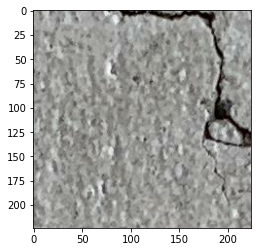

In [13]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [14]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 42.7 ms
(32, 224, 224, 3)
(32,)


Negative


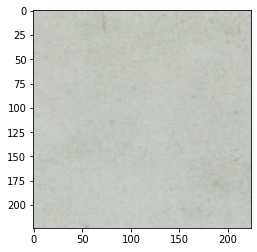

In [15]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [34]:
# Import the ResNet50 model
from tensorflow.keras.applications.resnet50 import ResNet50

# Instantiate the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
base_model.trainable = False

# Create a new model on top
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




In [35]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
history=model.fit(train_dataset, epochs=40, callbacks=[checkpoint , early_stop], validation_data=val_dataset)


Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.8967 - precision: 0.8790 - recall: 0.9200
Epoch 1: val_loss improved from inf to 0.03943, saving model to best_weights.h5
19/19 [==============================] - 9s 220ms/step - loss: 0.6156 - accuracy: 0.8967 - precision: 0.8790 - recall: 0.9200 - val_loss: 0.0394 - val_accuracy: 0.9900 - val_precision: 0.9804 - val_recall: 1.0000
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9700 - precision: 0.9764 - recall: 0.9633
Epoch 2: val_loss did not improve from 0.03943
19/19 [==============================] - 4s 139ms/step - loss: 0.2235 - accuracy: 0.9700 - precision: 0.9764 - recall: 0.9633 - val_loss: 0.0651 - val_accuracy: 0.9850 - val_precision: 0.9709 - val_recall: 1.0000
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9833 - precision: 0.9866 - recall: 0.9800
Epoch 3: val_loss did not improve from 0.03943
19/19 [

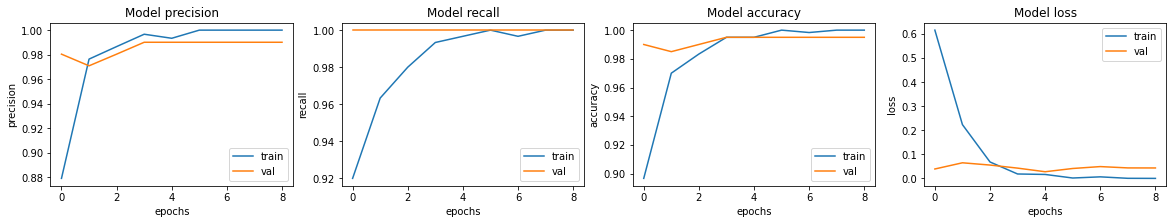

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

In [38]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

In [39]:
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [40]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


Negative


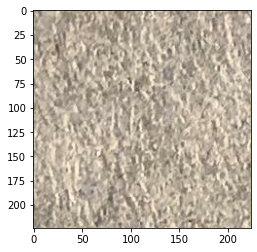

In [41]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [42]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

7/7 [==============================] - 2s 85ms/step - loss: 0.0217 - accuracy: 0.9950 - precision: 0.9901 - recall: 1.0000
 Testing Acc :  0.9950000047683716
 Testing Precision  0.9900990128517151
 Testing Recall  1.0


In [43]:
from sklearn.metrics import f1_score
f1=2*(prec*rec)/(prec+rec)
f1

0.9950248771119697